
# Audio Data Augmentation

**Author**: [Moto Hira](moto@meta.com)_

``torchaudio`` provides a variety of ways to augment audio data.

In this tutorial, we look into a way to apply effects, filters,
RIR (room impulse response) and codecs.

At the end, we synthesize noisy speech over phone from clean speech.


In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

1.13.0
0.13.0


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.




In [2]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

## Applying effects and filtering

:py:func:`torchaudio.sox_effects` allows for directly applying filters similar to
those available in ``sox`` to Tensor objects and file object audio sources.

There are two functions for this:

-  :py:func:`torchaudio.sox_effects.apply_effects_tensor` for applying effects
   to Tensor.
-  :py:func:`torchaudio.sox_effects.apply_effects_file` for applying effects to
   other audio sources.

Both functions accept effect definitions in the form
``List[List[str]]``.
This is mostly consistent with how ``sox`` command works, but one caveat is
that ``sox`` adds some effects automatically, whereas ``torchaudio``’s
implementation does not.

For the list of available effects, please refer to [the sox
documentation](http://sox.sourceforge.net/sox.html)_.

**Tip** If you need to load and resample your audio data on the fly,
then you can use :py:func:`torchaudio.sox_effects.apply_effects_file`
with effect ``"rate"``.

**Note** :py:func:`torchaudio.sox_effects.apply_effects_file` accepts a
file-like object or path-like object.
Similar to :py:func:`torchaudio.load`, when the audio format cannot be
inferred from either the file extension or header, you can provide
argument ``format`` to specify the format of the audio source.

**Note** This process is not differentiable.




In [3]:
# Load the data
waveform1, sample_rate1 = torchaudio.load(SAMPLE_WAV)

# Define effects
effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", "0.8"],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ["rate", f"{sample_rate1}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

print(waveform1.shape, sample_rate1)
print(waveform2.shape, sample_rate2)

torch.Size([2, 109368]) 44100
torch.Size([2, 136710]) 44100


Note that the number of frames and number of channels are different from
those of the original after the effects are applied. Let’s listen to the
audio.




In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

### Original:




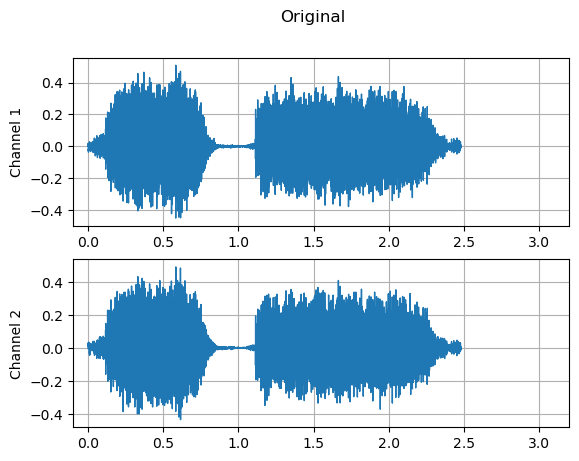

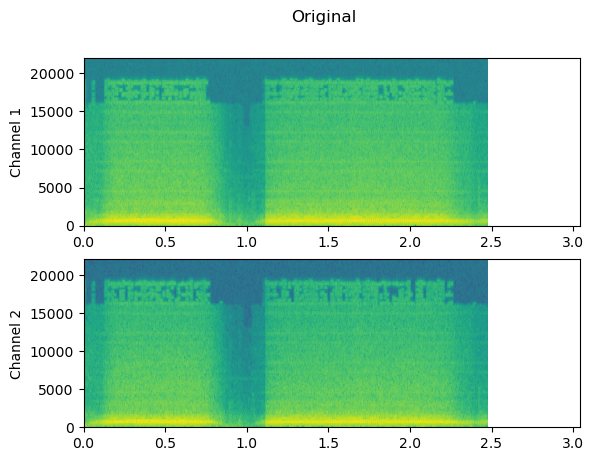

In [6]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
Audio(waveform1, rate=sample_rate1)

### Effects applied:




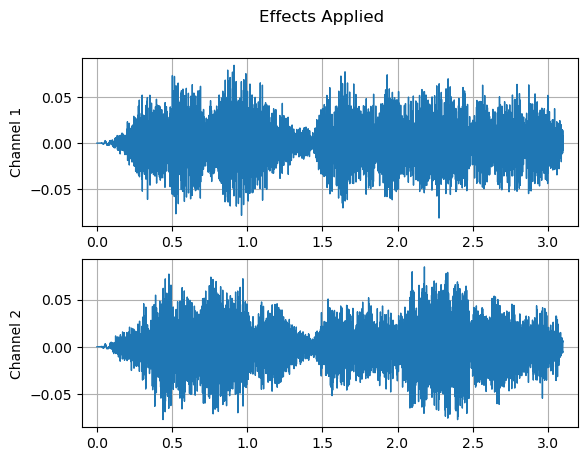

/Users/david/.conda/envs/ubm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


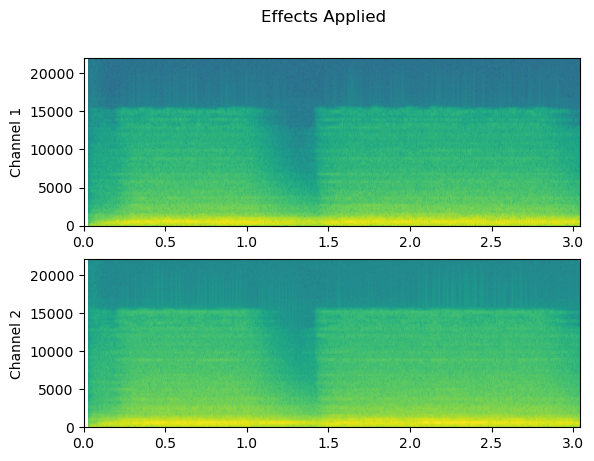

In [7]:
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2, rate=sample_rate2)

Doesn’t it sound more dramatic?




## Simulating room reverberation

[Convolution
reverb](https://en.wikipedia.org/wiki/Convolution_reverb)_ is a
technique that's used to make clean audio sound as though it has been
produced in a different environment.

Using Room Impulse Response (RIR), for instance, we can make clean speech
sound as though it has been uttered in a conference room.

For this process, we need RIR data. The following data are from the VOiCES
dataset, but you can record your own — just turn on your microphone
and clap your hands.




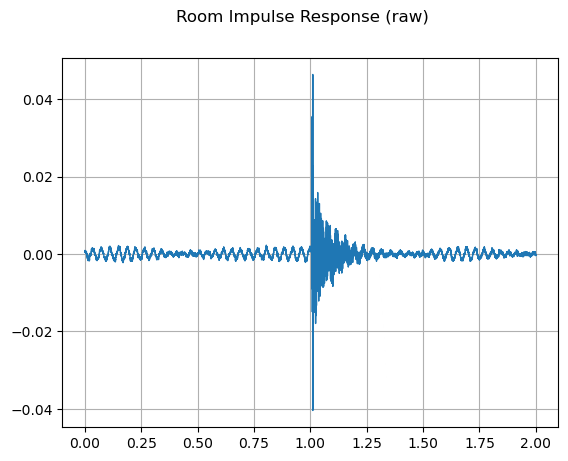

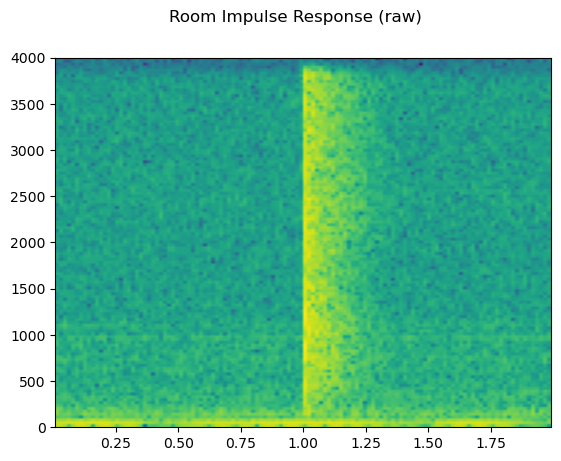

In [8]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

First, we need to clean up the RIR. We extract the main impulse, normalize
the signal power, then flip along the time axis.




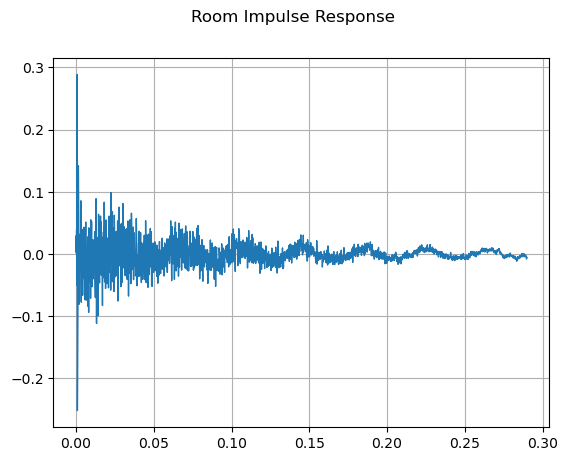

In [9]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.norm(rir, p=2)
RIR = torch.flip(rir, [1])

plot_waveform(rir, sample_rate, title="Room Impulse Response")

Then, we convolve the speech signal with the RIR filter.




In [10]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)

speech_ = torch.nn.functional.pad(speech, (RIR.shape[1] - 1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

### Original:




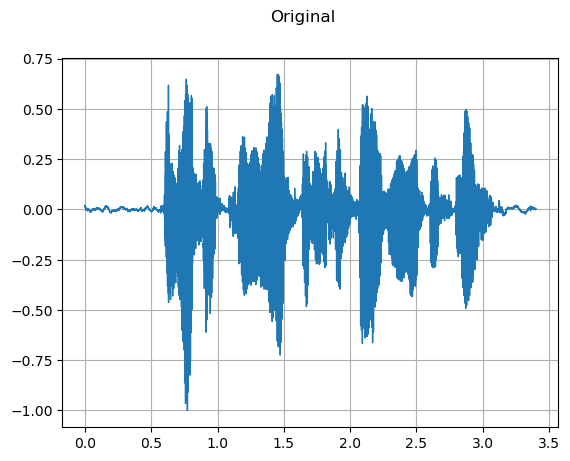

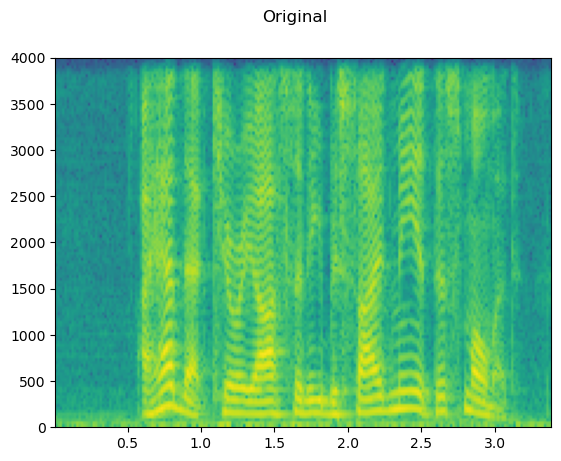

In [11]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR applied:




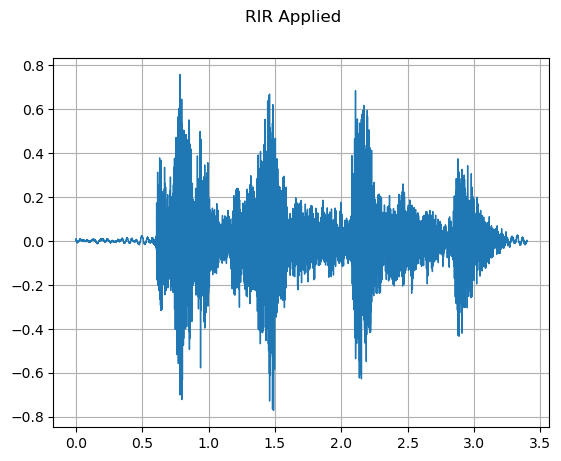

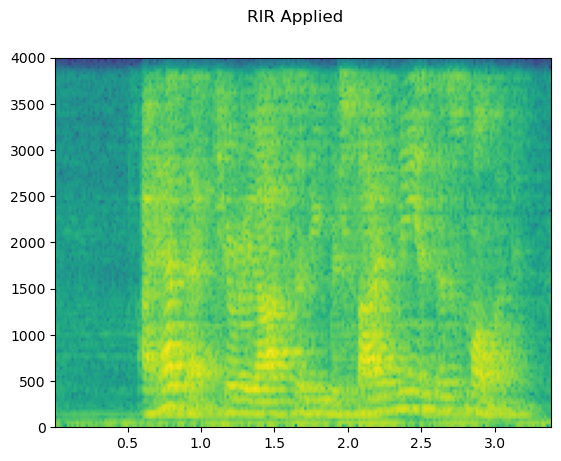

In [12]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

To add background noise to audio data, you can simply add a noise Tensor to
the Tensor representing the audio data. A common method to adjust the
intensity of noise is changing the Signal-to-Noise Ratio (SNR).
[[wikipedia](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)_]

$$ \\mathrm{SNR} = \\frac{P_{signal}}{P_{noise}} $$

$$ \\mathrm{SNR_{dB}} = 10 \\log _{{10}} \\mathrm {SNR} $$




In [13]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

speech_rms = speech.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * speech + noise) / 2)

### Background noise:




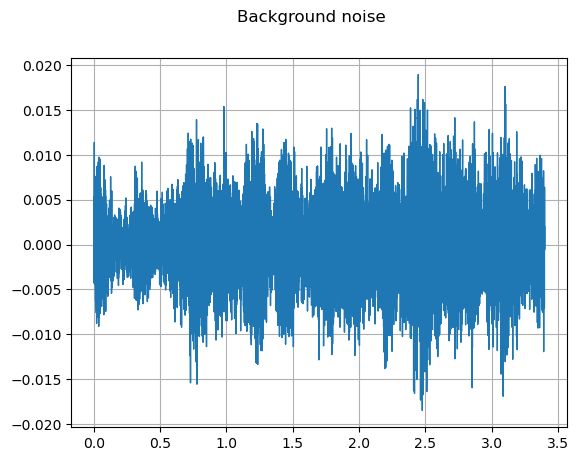

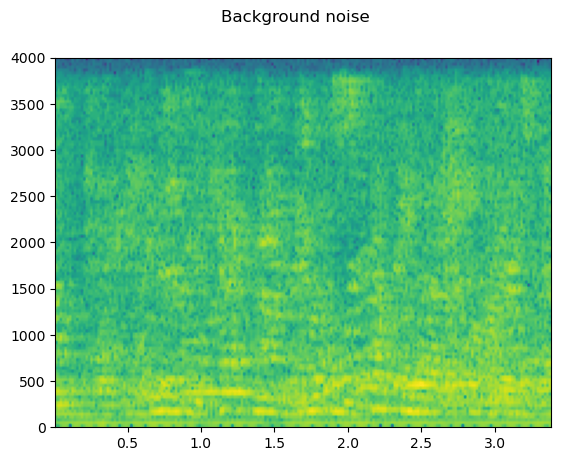

In [14]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

### SNR 20 dB:




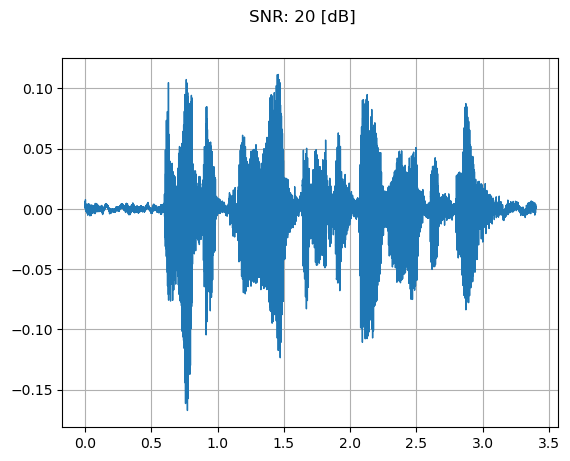

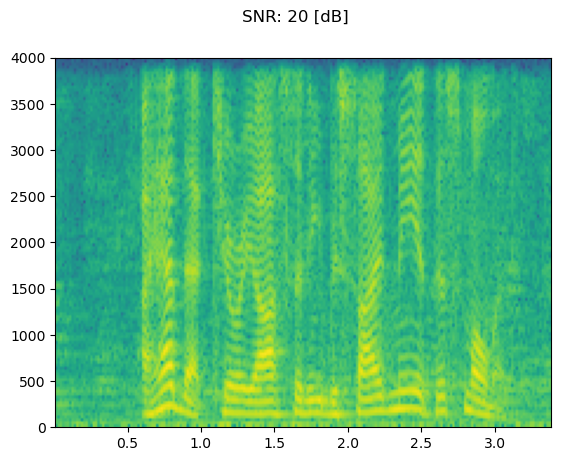

In [15]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 10 dB:




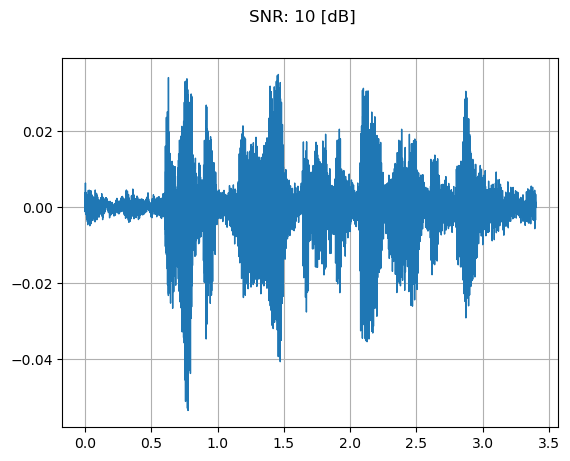

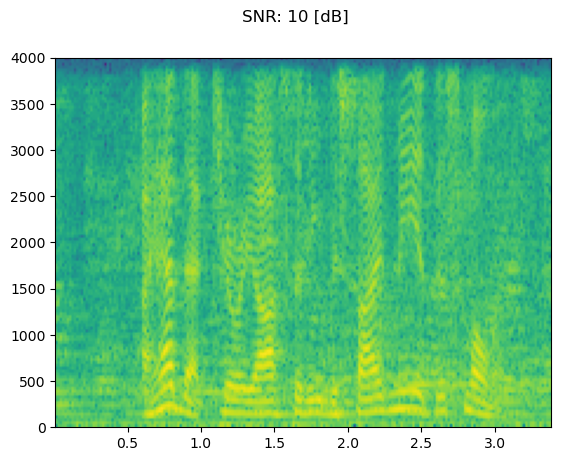

In [16]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 3 dB:




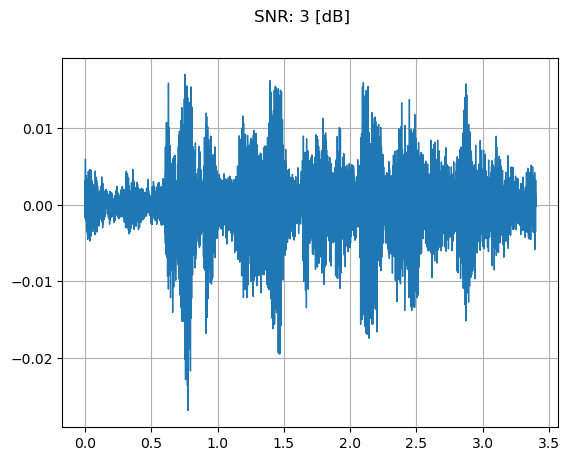

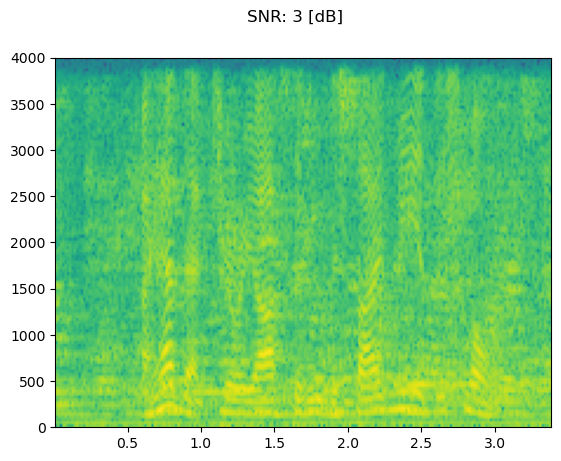

In [17]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

## Applying codec to Tensor object

:py:func:`torchaudio.functional.apply_codec` can apply codecs to
a Tensor object.

**Note** This process is not differentiable.




In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH)

configs = [
    {"format": "wav", "encoding": "ULAW", "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "vorbis", "compression": -1},
]
waveforms = []
for param in configs:
    augmented = F.apply_codec(waveform, sample_rate, **param)
    waveforms.append(augmented)

### Original:




In [ ]:
plot_waveform(waveform, sample_rate, title="Original")
plot_specgram(waveform, sample_rate, title="Original")
Audio(waveform, rate=sample_rate)

### 8 bit mu-law:




In [ ]:
plot_waveform(waveforms[0], sample_rate, title="8 bit mu-law")
plot_specgram(waveforms[0], sample_rate, title="8 bit mu-law")
Audio(waveforms[0], rate=sample_rate)

### GSM-FR:




In [ ]:
plot_waveform(waveforms[1], sample_rate, title="GSM-FR")
plot_specgram(waveforms[1], sample_rate, title="GSM-FR")
Audio(waveforms[1], rate=sample_rate)

### Vorbis:




In [ ]:
plot_waveform(waveforms[2], sample_rate, title="Vorbis")
plot_specgram(waveforms[2], sample_rate, title="Vorbis")
Audio(waveforms[2], rate=sample_rate)

## Simulating a phone recoding

Combining the previous techniques, we can simulate audio that sounds
like a person talking over a phone in a echoey room with people talking
in the background.




In [ ]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
speech_ = torch.nn.functional.pad(original_speech, (RIR.shape[1] - 1, 0))
rir_applied = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = 8
scale = (10 ** (snr_db / 20)) * noise.norm(p=2) / rir_applied.norm(p=2)
bg_added = (scale * rir_applied + noise) / 2

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
filtered, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    bg_added,
    sample_rate,
    effects=[
        ["lowpass", "4000"],
        [
            "compand",
            "0.02,0.05",
            "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8",
            "-8",
            "-7",
            "0.05",
        ],
        ["rate", "8000"],
    ],
)

plot_specgram(filtered, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = F.apply_codec(filtered, sample_rate2, format="gsm")

plot_specgram(codec_applied, sample_rate2, title="GSM Codec Applied")

### Original speech:




In [ ]:
Audio(original_speech, rate=sample_rate)

### RIR applied:




In [ ]:
Audio(rir_applied, rate=sample_rate)

### Background noise added:




In [ ]:
Audio(bg_added, rate=sample_rate)

### Filtered:




In [ ]:
Audio(filtered, rate=sample_rate2)

### Codec applied:




In [ ]:
Audio(codec_applied, rate=sample_rate2)